In [1]:
import json
import pickle

from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
from scipy.linalg import norm

from sklearn.decomposition import PCA, TruncatedSVD

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import pandas as pd
import numpy as np


In [2]:
with open("stored_variables/user_subreddit_tf.pickle", "rb") as f:
    subreddit_tf = pickle.load(f)

In [3]:
with open("stored_variables/user_subreddit_df_mat.pickle", "rb") as f:
    subreddit_df_mat = pickle.load(f)

In [4]:
with open("stored_variables/user_subreddit_tf_auths.pickle", "rb") as f:
    author_names = pickle.load(f)

In [5]:
with open("stored_variables/user_subreddit_tf_subreddit_names.pickle", "rb") as f:
    subreddit_reverse_dict = pickle.load(f)

In [6]:
norm(np.array([[1,10,100],[2,20,200]]), ord=2, axis=1)

array([100.50373127, 201.00746255])

## Cosine similarity

In [7]:
subreddit_tf_c = coo_matrix(subreddit_tf)

In [8]:
subreddit_df_c = coo_matrix(subreddit_df_mat)

In [9]:
subreddit_idf = subreddit_df_c.sum() / subreddit_df_c.sum(axis=0)

In [10]:
subreddit_tfidf = csr_matrix(subreddit_tf_c.multiply(subreddit_idf))

In [11]:
subreddit_tfidf_norms = np.zeros(subreddit_tfidf.shape[0])

In [12]:
subreddit_tfidf_norms[:1000] = norm(subreddit_tfidf[:1000,:].toarray(), axis=1)

In [13]:
for i in range(20):
    subreddit_tfidf_norms[i*1000 : (i+1) * 1000] = norm(subreddit_tfidf[i*1000 : (i+1) * 1000].toarray(), axis=1)

In [14]:
subreddit_tfidf_normalized = csr_matrix(subreddit_tfidf / subreddit_tfidf_norms[:, np.newaxis])

In [64]:
subreddit_cosine_sims = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [65]:
for i in range(20):
    chunk1 = subreddit_tfidf_normalized[i*1000 : (i+1)*1000, :]
    for j in range(20):
        chunk2 = subreddit_tfidf_normalized[j*1000 : (j+1)*1000, :]
        subreddit_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(csc_matrix(chunk2.T)).toarray()


In [71]:
for i in range(subreddit_tfidf.shape[0]):
    subreddit_cosine_sims[i,i] = 0

In [72]:
with open("stored_variables/user_subreddit_tfidf_cossims.pickle", "wb") as f:
    pickle.dump(subreddit_cosine_sims, f)

In [73]:
most_similar_user = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [74]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user[i] = np.argsort(subreddit_cosine_sims[i])[-1]

In [75]:
most_similar_user[:10]

array([12734, 16299, 11530, 16466, 14127,  5294,   535,  1117, 17327,
       15723], dtype=int32)

In [76]:
[subreddit_cosine_sims[i, most_similar_user[i]] for i in range(10)]

[0.27577932149851536,
 0.6913537432662556,
 0.6066522521835037,
 0.10599369874682485,
 0.046114918042816574,
 0.6956703068143236,
 0.3145082088881593,
 0.3518339808242445,
 0.9608536521525342,
 0.21971478088485033]

## Check similarities by subreddits authors commented in

In [26]:
author_reverse_dict = {author_names[i]:i for i in range(len(author_names))}

In [27]:
num_sanders = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['sandersforpresident']]) for k in author_names}
num_trump = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['the_donald']]) for k in author_names}
num_clinton = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hillaryclinton']]) for k in author_names}
num_politics = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['politics']]) for k in author_names}


In [28]:
comment_threshold = 10

In [29]:
sanders_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] >= comment_threshold]
trump_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_trump[author_names[i]] >= comment_threshold]
clinton_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_clinton[author_names[i]] >= comment_threshold]

In [30]:
none_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] == 0 and 
                     num_trump[author_names[i]] == 0 and
                     num_clinton[author_names[i]] == 0]

In [51]:
print(len(sanders_user_indices))
print(len(trump_user_indices))
print(len(clinton_user_indices))
print(len(none_user_indices))

1557
919
137
12958


In [52]:
print(len(set(sanders_user_indices).intersection(trump_user_indices)))
print(len(set(sanders_user_indices).intersection(clinton_user_indices)))
print(len(set(trump_user_indices).intersection(clinton_user_indices)))

206
73
18


In [79]:
np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.0023532229758504207

In [80]:
np.sum(subreddit_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.0080624210345887

In [81]:
np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.01608285908823672

In [108]:
np.sum(subreddit_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.003098167220513023

In [111]:
np.sum(subreddit_cosine_sims) / (subreddit_cosine_sims.shape[0] * (subreddit_cosine_sims.shape[1] - 1))

0.0021184202746371466

In [110]:
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.0015643870341334018
0.0026954114996483023
0.001624365310504976

0.0012973510561752502
0.0013305669655459414
0.001691007118048718


In [104]:
print(len(set(most_similar_user[sanders_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[sanders_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[sanders_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user[trump_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[trump_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[trump_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user[clinton_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[clinton_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[clinton_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))



167
0.10725754656390495
71
0.07725788900979326
9
0.06569343065693431

57
0.036608863198458574
89
0.09684439608269858
4
0.029197080291970802

14
0.00899165061014772
6
0.006528835690968444
3
0.021897810218978103


In [94]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(subreddit_cosine_sims[i,j])

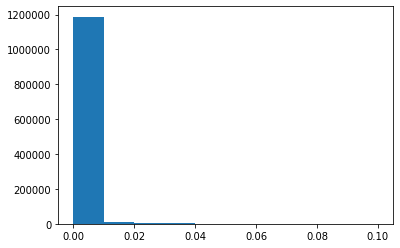

In [96]:
plt.hist(sanders_sanders_sims, range = (0, 0.1))
plt.show()

In [97]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(subreddit_cosine_sims[i,j])

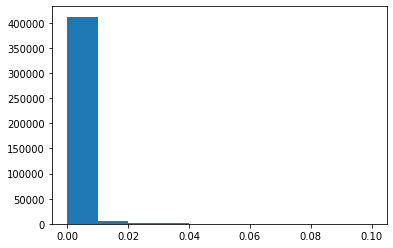

In [99]:
plt.hist(trump_trump_sims, range = (0,0.1))
plt.show()

In [100]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(subreddit_cosine_sims[i,j])

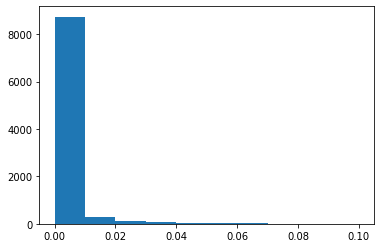

In [101]:
plt.hist(clinton_clinton_sims, range = (0,0.1))
plt.show()

## Use SVD

In [15]:
user_svd = TruncatedSVD(n_components = 100)
user_svd_points = user_svd.fit_transform(subreddit_tfidf)

In [16]:
user_svd_norms = np.zeros(subreddit_tfidf.shape[0])

In [17]:
for i in range(20):
    user_svd_norms[i*1000 : (i+1) * 1000] = norm(user_svd_points[i*1000 : (i+1) * 1000], axis=1)

In [18]:
user_svd_norms[:10]

array([203105.72096635,   4847.69760715,  16960.03585867, 209036.96304267,
         2338.87442073,   3345.05274884, 321894.55026444,   4258.10816698,
       131248.62912042,  21569.40615956])

In [19]:
user_svd_normalized = user_svd_points / user_svd_norms[:, np.newaxis]

In [19]:
svd_cosine_sims = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [27]:
user_svd_normalized[:1000].dot(user_svd_normalized[:1000].T)

array([[ 1.        ,  0.02992293,  0.10480739, ...,  0.02865939,
         0.04208495,  0.01784682],
       [ 0.02992293,  1.        ,  0.25835802, ...,  0.18008577,
         0.4314537 ,  0.48675799],
       [ 0.10480739,  0.25835802,  1.        , ...,  0.17254001,
         0.24262247,  0.22627591],
       ...,
       [ 0.02865939,  0.18008577,  0.17254001, ...,  1.        ,
        -0.02405827,  0.30856092],
       [ 0.04208495,  0.4314537 ,  0.24262247, ..., -0.02405827,
         1.        ,  0.50179591],
       [ 0.01784682,  0.48675799,  0.22627591, ...,  0.30856092,
         0.50179591,  1.        ]])

In [30]:
for i in range(20):
    chunk1 = csr_matrix(user_svd_normalized[i*1000 : (i+1)*1000, :])
    for j in range(i,20):
        chunk2 = csc_matrix(user_svd_normalized[j*1000 : (j+1)*1000, :].T)
        svd_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(chunk2).toarray()


In [33]:
svd_cosine_sims[:10,:10]

array([[ 1.00000000e+00,  2.99229309e-02,  1.04807393e-01,
         2.22527172e-02,  5.81757494e-01,  4.52440777e-01,
        -8.62572321e-03,  1.98286582e-01,  1.44032659e-03,
         4.13870959e-02],
       [ 2.99229309e-02,  1.00000000e+00,  2.58358019e-01,
         5.69887075e-01,  5.47077247e-01,  4.75087395e-01,
         4.90846061e-02,  4.99744218e-01,  4.58734668e-03,
         1.02536677e-01],
       [ 1.04807393e-01,  2.58358019e-01,  1.00000000e+00,
         8.73261285e-01,  5.81072226e-01,  8.13921715e-01,
        -2.63067979e-02,  4.50903820e-01,  2.50981262e-03,
         9.37020929e-01],
       [ 2.22527172e-02,  5.69887075e-01,  8.73261285e-01,
         1.00000000e+00,  6.95194895e-01,  8.11223315e-01,
         5.24289151e-02,  4.49924913e-01,  6.99312580e-04,
         8.61829575e-01],
       [ 5.81757494e-01,  5.47077247e-01,  5.81072226e-01,
         6.95194895e-01,  1.00000000e+00,  8.61830761e-01,
        -3.44704287e-02,  5.35698315e-01,  3.79862391e-03,
         5.

In [34]:
for i in range(subreddit_tfidf.shape[0]):
    svd_cosine_sims[i,i] = 0

In [35]:
for i in range(20):
    for j in range(i):
        svd_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = \
svd_cosine_sims[j*1000 : (j+1)*1000, i*1000 : (i+1)*1000].T

In [38]:
svd_cosine_sims[3872,10415]

0.11908674176941285

In [39]:
svd_cosine_sims[10415,3872]

0.11908674176941285

In [20]:
# with open("stored_variables/user_subreddit_tfidf_cossims_svd.pickle", "wb") as f:
#     pickle.dump(svd_cosine_sims, f)
    
with open("stored_variables/user_subreddit_tfidf_cossims_svd.pickle", "rb") as f:
    svd_cosine_sims = pickle.load(f)

In [21]:
most_similar_user_svd = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [22]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user_svd[i] = np.argsort(svd_cosine_sims[i])[-1]

In [23]:
most_similar_user_svd[:10]

array([ 2014, 13342,  8272, 19624,   169, 19360,   535,  9748, 14650,
       15290], dtype=int32)

In [24]:
[svd_cosine_sims[i, most_similar_user_svd[i]] for i in range(10)]

[0.999470033202358,
 0.9952106624511369,
 0.9675453485667704,
 0.9967579707061056,
 0.9941043289147825,
 0.9179101077098986,
 0.9573685133150818,
 0.9460518834135123,
 0.9948822238602678,
 0.9923576814567933]

In [31]:
np.sum(svd_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.1012734687426595

In [54]:
np.sum(svd_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.10579011588931087

In [55]:
np.sum(svd_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.18899739670867832

In [56]:
np.sum(svd_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.11579555046872082

In [57]:
np.sum(svd_cosine_sims) / (svd_cosine_sims.shape[0] * (svd_cosine_sims.shape[1] - 1))

0.10881763054298746

In [58]:
print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(svd_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.09728033854309406
0.10974144952721615
0.10699306966968032

0.10587713758110265
0.10240165710703053
0.10757639761310547


In [59]:
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd[sanders_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd[trump_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user_svd[clinton_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))



132
0.08477842003853564
72
0.07834602829162132
15
0.10948905109489052

52
0.033397559409120106
64
0.06964091403699674
10
0.072992700729927

13
0.008349389852280027
7
0.007616974972796518
10
0.072992700729927


In [60]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(svd_cosine_sims[i,j])

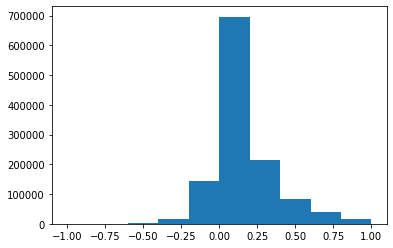

In [66]:
plt.hist(sanders_sanders_sims, range = (-1,1))
plt.show()

In [62]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(svd_cosine_sims[i,j])

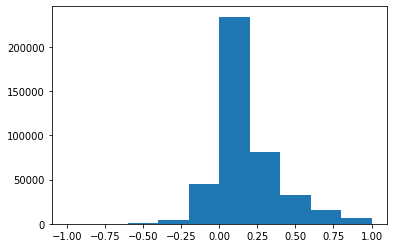

In [67]:
plt.hist(trump_trump_sims, range = (-1,1) )
plt.show()

In [64]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(svd_cosine_sims[i,j])

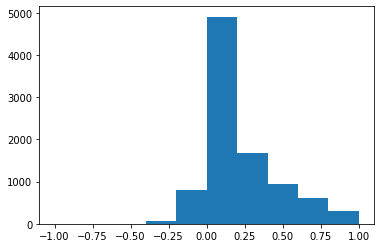

In [68]:
plt.hist(clinton_clinton_sims, range = (-1,1))
plt.show()

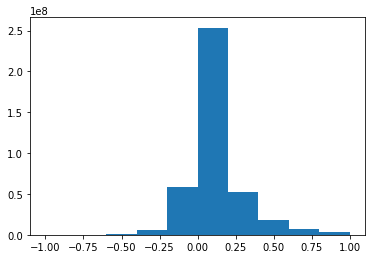

In [82]:
plt.hist(svd_cosine_sims.flatten(), range=(-1,1))
plt.show()

In [33]:
most_similar_50_users_svd = np.zeros((subreddit_tfidf.shape[0],50), dtype = np.int32)

for i in range(subreddit_tfidf.shape[0]):
    most_similar_50_users_svd[i] = np.flip(np.argsort(svd_cosine_sims[i])[-50:])


In [34]:
most_similar_50_users_svd[0]

array([ 2014, 11177,  6489,  8742, 18778,  4138, 17553, 18470, 16614,
       12191, 13646,   763,  4184,  1631, 17163,  1624, 11452,   572,
        1930, 12713,  2415, 17363,  1672,  4266,  9701,  4623,  3682,
        2935,  4372, 14925, 16930, 19080, 15235, 10472,  8419, 18879,
        5172,  5570,    82,  9181,  8708,  1250,  5355, 10323,  8702,
        1217,  8215, 12848,  7168, 15614], dtype=int32)

In [35]:
most_similar_50_set = [set(i) for i in most_similar_50_users_svd]

In [53]:
print(np.mean([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 10]))


4.77713551701991
4.0
103.33847141939627
389.0147058823529


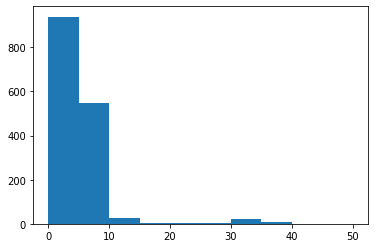

In [38]:
plt.hist([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

In [41]:
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 30]))

68
32


4.430903155603917
2.0
91
35
97.14907508161045
184.94505494505495


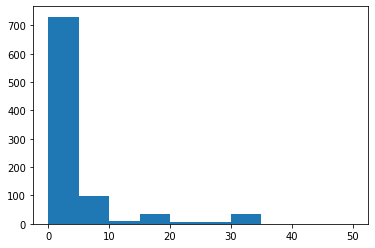

In [52]:
print(np.mean([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

2.576642335766423
0.0
21
0
95.81751824817518
224.57142857142858


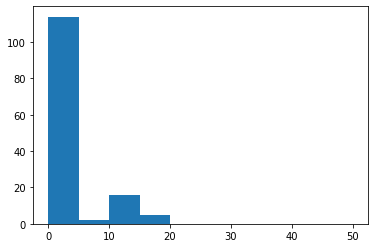

In [51]:
print(np.mean([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 10]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 30]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 10]))


plt.hist([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

## Try with Music and HipHopHeads

In [44]:
num_music = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['music']]) for k in author_names}
num_hhh = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hiphopheads']]) for k in author_names}


In [45]:
music_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_music[author_names[i]] >= comment_threshold]
print(len(music_user_indices))
hhh_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_hhh[author_names[i]] >= comment_threshold]
print(len(hhh_user_indices))


2176
590


In [54]:
np.sum(svd_cosine_sims[music_user_indices, :][:,music_user_indices]) / \
(len(music_user_indices) * (len(music_user_indices)-1))

0.11300748637964096

In [55]:
np.sum(svd_cosine_sims[hhh_user_indices, :][:,hhh_user_indices]) / \
(len(hhh_user_indices) * (len(hhh_user_indices)-1))

0.10838394926950977

In [56]:
print(np.sum(svd_cosine_sims[music_user_indices, :][:,hhh_user_indices]) / \
((len(music_user_indices) * len(hhh_user_indices)) - \
len(set(music_user_indices).intersection(hhh_user_indices))))


0.09534066326656189


In [59]:
print(len(set(most_similar_user_svd[music_user_indices]).intersection(music_user_indices)))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(music_user_indices))/len(music_user_indices))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(hhh_user_indices)))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(hhh_user_indices))/len(hhh_user_indices))

print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(hhh_user_indices)))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(hhh_user_indices))/len(hhh_user_indices))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(music_user_indices)))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(music_user_indices))/len(music_user_indices))

257
0.11810661764705882
67
0.1135593220338983
54
0.09152542372881356
82
0.03768382352941176


In [60]:
music_music_sims = []

for i in range(len(music_user_indices)):
    for j in range(i+1, len(music_user_indices)):
        music_music_sims.append(svd_cosine_sims[i,j])

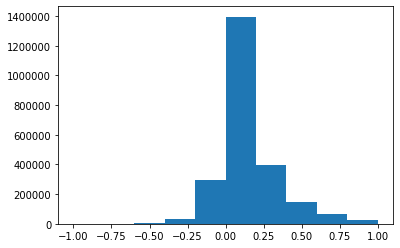

In [61]:
plt.hist(music_music_sims, range = (-1,1))
plt.show()

In [62]:
hhh_hhh_sims = []

for i in range(len(hhh_user_indices)):
    for j in range(i+1, len(hhh_user_indices)):
        hhh_hhh_sims.append(svd_cosine_sims[i,j])

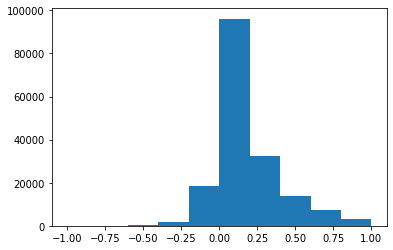

In [64]:
plt.hist(hhh_hhh_sims, range = (-1,1) )
plt.show()

5.9453125
6.0
209
0
37.385110294117645
41.90430622009569


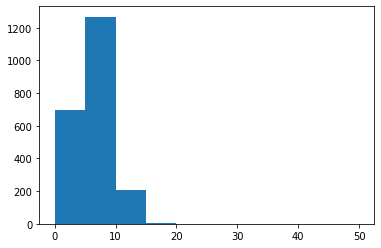

In [65]:
print(np.mean([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices]))
print(sum([1 for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 10]))
print(sum([1 for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 30]))
print(np.mean([num_music[author_names[i]] for i in music_user_indices]))
print(np.mean([num_music[author_names[i]] for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices], range = (0,50))
plt.show()

4.244067796610169
2.0
88
1
128.61016949152543
244.4318181818182


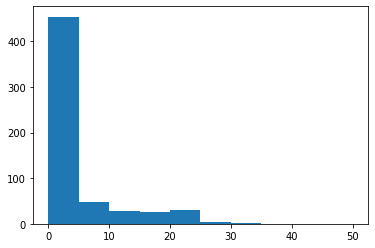

In [66]:
print(np.mean([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices]))
print(sum([1 for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 10]))
print(sum([1 for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 30]))
print(np.mean([num_hhh[author_names[i]] for i in hhh_user_indices]))
print(np.mean([num_hhh[author_names[i]] for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices], range = (0,50))
plt.show()